In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy

np.random.seed(0)

In [2]:
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
import pandas as pd


def TuneData(X, y):
    scaled_X  = StandardScaler().fit_transform(X)
    intercept_X = np.hstack([scaled_X, np.ones(shape=(X.shape[0], 1))])
    perm = list(range(X.shape[0]))
    np.random.shuffle(perm)
    return intercept_X[perm, :], y[perm].reshape(-1, 1)

def ReadDiabData():
    diabetes = load_diabetes()
    X, y = diabetes.data, diabetes.target
    return TuneData(X, y)

def ReadWeatherData():
    df = pd.read_csv("weatherHistory.csv")
    X = df[["Wind Speed (km/h)", "Humidity", "Wind Bearing (degrees)", "Visibility (km)", "Loud Cover", "Pressure (millibars)", "Temperature (C)"]].to_numpy()
    y = df["Temperature (C)"].to_numpy()
    return TuneData(X, y)


In [3]:
from typing import List, Union, Dict

def MaxEigval(M : np.ndarray) -> np.float32:
        return np.max(np.abs(scipy.linalg.eigvalsh(M)))

def Hessian(X : np.ndarray) -> np.ndarray:
    return (X.T @ X) / X.shape[0]

class RidgeData:
    def FindRidgeOptimal(X : np.ndarray, y : np.ndarray, lam : float) -> np.ndarray:
        return np.linalg.inv(X.T @ X + (lam * X.shape[0]) * np.eye(X.shape[1])) @ X.T @ y
    
    def FindL(X : np.ndarray, lam : float) -> np.float32:
        return MaxEigval(Hessian(X)) + lam
    
    def EstimateAllL(xs : List[np.ndarray], lam : float) -> List[np.float32]:
        return [RidgeData.FindL(np.vstack(xs), lam)] + [RidgeData.FindL(X_i, lam) for X_i in xs]

    def EstimateL(xs : List[np.ndarray], lam : float) -> np.float32:
        return np.max(RidgeData.EstimateAllL(xs, lam))
    
    def EstimateLsum(xs : List[np.ndarray], lam : float) -> np.float32:
        return RidgeData.FindL(np.vstack(xs), lam) 
    
    def EstimateLq(xs : List[np.ndarray], lam : float) -> np.float32:
        return RidgeData.FindL(xs[0], lam)
    
    def EstimateLp(xs : List[np.ndarray], lam : float) -> np.float32:
        HessianP = np.mean([Hessian(X) for X in xs], axis=0) - Hessian(xs[0])
        return MaxEigval(HessianP)
    
    def EstimateDelta(xs : List[np.ndarray]) -> np.float32:
        Hessian_g = Hessian(xs[0])
        return np.max([MaxEigval(Hessian_g - Hessian(X_i)) for X_i in xs])

    def __init__(self, lam : float, num_workers : int, num_feat : int, cnt_worker_data : int, delta_mult : float, synthetic : bool = True):
        self.num_workers = num_workers
        self.num_feat = num_feat
        self.cnt_worker_data = cnt_worker_data
        self.lam = lam

        self.ys = []
        self.xs = []

        if synthetic:
            w = np.random.normal(size=(num_feat, 1))
            for i in range(num_workers):
                if i == 0:
                    x = np.random.normal(size=(cnt_worker_data, num_feat))
                    self.xs.append(x)
                    self.ys.append(x @ w + np.random.normal(size=(cnt_worker_data, 1)))
                else:
                    x = self.xs[0] + np.random.normal(size=(cnt_worker_data, num_feat)) * delta_mult
                    self.xs.append(x)
                    self.ys.append(x @ w + np.random.normal(size=(cnt_worker_data, 1)))
        else:
            X, y = ReadWeatherData()
            assert cnt_worker_data * num_workers <= X.shape[0]
            for i in range(num_workers):
                left, right = i * cnt_worker_data, (i + 1) * cnt_worker_data
                self.xs.append(X[left : right, :])
                self.ys.append(y[left : right, :])
            self.num_feat = X.shape[1]

            
        self.w_star = RidgeData.FindRidgeOptimal(X = np.vstack(self.xs), y = np.vstack(self.ys), lam=lam)
        self.L = RidgeData.EstimateLsum(xs=self.xs, lam=lam)
        self.Lp = RidgeData.EstimateLp(xs=self.xs, lam=lam)
        self.Lq = RidgeData.EstimateLq(xs=self.xs, lam=lam)
        self.delta = RidgeData.EstimateDelta(xs=self.xs)
        self.mu = lam
    
    def __repr__(self) -> str:
        return "num_workers: {}; d: {}; cnt_worker_data: {};\ndelta: {}; L: {}; Lp: {}; Lq: {}; mu: {};".format(
                self.num_workers, self.num_feat, self.cnt_worker_data, self.delta, self.L, self.Lp, self.Lq, self.mu
                )

    def Loss(self, w : np.ndarray) -> np.float32:
        X = np.vstack(self.xs)
        y = np.vstack(self.ys)
        return 1 / (2 * X.shape[0]) * (np.linalg.norm(X @ w - y) ** 2) + 1 / (2 * self.lam) * (np.linalg.norm(w) ** 2)
    
    def Error(self, w : np.ndarray) -> np.float32:
        return np.linalg.norm(w - self.w_star) ** 2

In [4]:
from typing import List, Tuple
from abc import ABC, abstractmethod


class Optimizer(ABC):
    def __init__(self, data : RidgeData):
        self.communications = 0
        self.local_calls = 0 
        self.data = data

    def local_gradient(self, id : int, w : np.ndarray) -> np.ndarray:
        self.local_calls += 1
        X, y = self.data.xs[id], self.data.ys[id]
        return (1/self.data.cnt_worker_data) * (X.T @ X @ w - X.T @ y) + self.data.lam * w 
    
    def r_gradient(self, w : np.ndarray) -> np.ndarray:
        self.communications += 1
        return np.mean([self.local_gradient(i, w) for i in range(self.data.num_workers)], axis=0)
    
    def p_gradient(self, w : np.ndarray) -> np.ndarray:
        self.communications += 1
        gradient_1 = self.local_gradient(0, w)
        result = np.zeros(w.shape)
        n = self.data.num_workers
        for i in range(1, n):
            result += (1 / n) * (self.local_gradient(i, w) -  gradient_1)
        return result
    
    def q_gradient(self, w : np.ndarray) -> np.ndarray:
        return self.local_gradient(0, w)
    
    @abstractmethod
    def init_optimization(self):
        ...
    
    @abstractmethod
    def step(self):
        ...
    
    def optimize(self, K : int = 100) -> Tuple[np.ndarray, List[int]]:
        self.init_optimization()
        start_err = self.data.Error(self.w)
        rel_errs = []
        local_calls = []
        communications = []
        for i in range(K):
            self.step()
            rel_errs.append(self.data.Error(self.w) / start_err)
            local_calls.append(self.local_calls)
            communications.append(self.communications)
        return rel_errs, local_calls, communications


class DummyGradient(Optimizer):
    def init_optimization(self):
        self.eta = 1 / self.data.L
        self.w = np.zeros(shape=(self.data.num_feat, 1))

    def step(self):
        self.w = self.w - self.eta * self.r_gradient(self.w)


class AcGD(Optimizer):
    def init_optimization(self):
        self.y = self.w = np.zeros(shape=(self.data.num_feat, 1))
        self.kappa = self.data.L / self.data.mu
        self.coef = (np.sqrt(self.kappa) - 1) / (np.sqrt(self.kappa) + 1)
    
    def step(self):
        y_prev = self.y
        self.y = self.w - (1 / self.data.L) * self.r_gradient(self.w)
        self.w = (1 + self.coef) * self.y - self.coef * y_prev

class AcGDStable(Optimizer):
    def init_optimization(self):
        self.y = self.w = np.zeros(shape=(self.data.num_feat, 1))
        self.kappa = self.data.L / self.data.mu
        self.coef = 0.5 * (np.sqrt(self.kappa) - 1) / (np.sqrt(self.kappa) + 1)
    
    def step(self):
        y_prev = self.y
        self.y = self.w - (1 / self.data.L) * self.r_gradient(self.w)
        self.w = (1 + self.coef) * self.y - self.coef * y_prev

class AccExtra(Optimizer):
    def solve_subproblem(self, x_g, tol = 1e-12):
        theta = 1 / (2 * self.data.Lp)
        L = 2 * self.data.Lp + self.data.Lq
        mu = 1 / theta + self.data.mu
        kappa = L / mu
        # for some reason acceliration does not work well
        coef = 0 * (np.sqrt(kappa) - 1) / (np.sqrt(kappa) + 1) 

        grad_p_x_g = self.p_gradient(x_g)
        grad_A_x_f = lambda x : grad_p_x_g + (1 / theta) * (x - x_g) + self.q_gradient(x)
        
        y = x_f = x_g
        prev_norm = None

        while True:
            grad = grad_A_x_f(x_f)
            norm = np.linalg.norm(grad)
            if norm <= self.data.Lp * np.linalg.norm(x_f - x_g):
                return x_f
            if prev_norm is not None and prev_norm - norm <= tol:
                return x_f
            prev_norm = norm

            y_prev = y
            y = x_f - (1 / L) * grad
            x_f = (1 + coef) * y - coef * y_prev
    
    def init_optimization(self):
        self.tau = min(1, np.sqrt(self.data.mu) / (2 * np.sqrt(self.data.Lp)))
        self.eta = min(1 / (2 * self.data.mu), 1 / (2 * np.sqrt(self.data.mu * self.data.Lp)))
        self.alpha = self.data.mu
        self.w = self.x_f = np.zeros(shape=(self.data.num_feat, 1))

    def step(self):
        x_g = self.tau * self.w + (1 - self.tau) * self.x_f
        self.x_f = self.solve_subproblem(x_g)
        self.w = self.w + self.eta * self.alpha * (self.x_f - self.w) - self.eta * self.r_gradient(self.x_f)


class AccExtraDefault(AccExtra):
    def solve_subproblem(self, x_g):
        x_f = x_g
        theta = 1 / (2 * self.data.Lp)
        eta = 1 / (2 * self.data.Lp + self.data.Lq)
        grad_p_xg = self.p_gradient(x_g)

        tol = 1e-18
        prev = None
        while True:
            grad_a_xf = grad_p_xg + (x_f - x_g) / theta + self.q_gradient(x_f)
            grad_norm = np.linalg.norm(grad_a_xf)
            if (prev is not None and prev - grad_norm < tol):
                return x_f
            prev = grad_norm
    
            x_f = x_f - eta * grad_a_xf

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10, 4)
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.size'] = 12
mpl.rcParams['grid.color'] = 'gray'
mpl.rcParams['grid.linestyle'] = '--'


fav_markers = ["X", "D", "s", "o", "v"]
def plot_errs(method_dicts : Dict[str, Tuple[np.ndarray, List[int]]], synthetic : bool, tol = 1e-12):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    for id, item in enumerate(method_dicts.items()):
        name, values = item
        errors, calls, communications = values
        for k in range(len(errors)):
            if errors[k] < tol:
                errors = errors[:k + 1]
                calls = calls[:k + 1]
                communications = communications[:k + 1]
                break
        if name == "My ACEG":
            print(communications[-1], calls[-1])
        ax1.plot(communications, errors, label=name, marker=fav_markers[id], markevery=5)
        ax2.plot(calls, errors, label=name,marker=fav_markers[id], markevery=5)

    
    fig.supylabel('$||w^{n} - w^*||^2 / ||w^0 - w^*||^2$')
    for ax, title in zip((ax1, ax2), ("Communications, n", "Local calls, n")):
        ax.set_xlabel(title)
        ax.set_yscale('log')

    fig.suptitle("Synthetic" if synthetic else "Temperature prediction")
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.show()

In [6]:
def MakeExperiment(synthetic : bool = True):
    methods = {"Default gradient" : DummyGradient,
               "AcGD" : AcGD,
               "My ACEG" : AccExtra,
               "Default ACEG" : AccExtraDefault,
               "AcGDStable" : AcGDStable
               }
    if synthetic:
        data = RidgeData(0.1, num_feat=50, num_workers=25, cnt_worker_data=100, delta_mult=0.1)
    else:
        k = 25
        data = RidgeData(0.2, num_workers=k, num_feat=10, cnt_worker_data=80000//k, delta_mult=0.1, synthetic=False)
    print(data)
    plot_errs({key : method(data=data).optimize() for key, method in methods.items()}, synthetic=synthetic, tol=1e-12)

num_workers: 25; d: 50; cnt_worker_data: 100;
delta: 0.24304882039757858; L: 2.853938343406003; Lp: 0.04891662948641749; Lq: 2.8501331564222796; mu: 0.1;
22 655


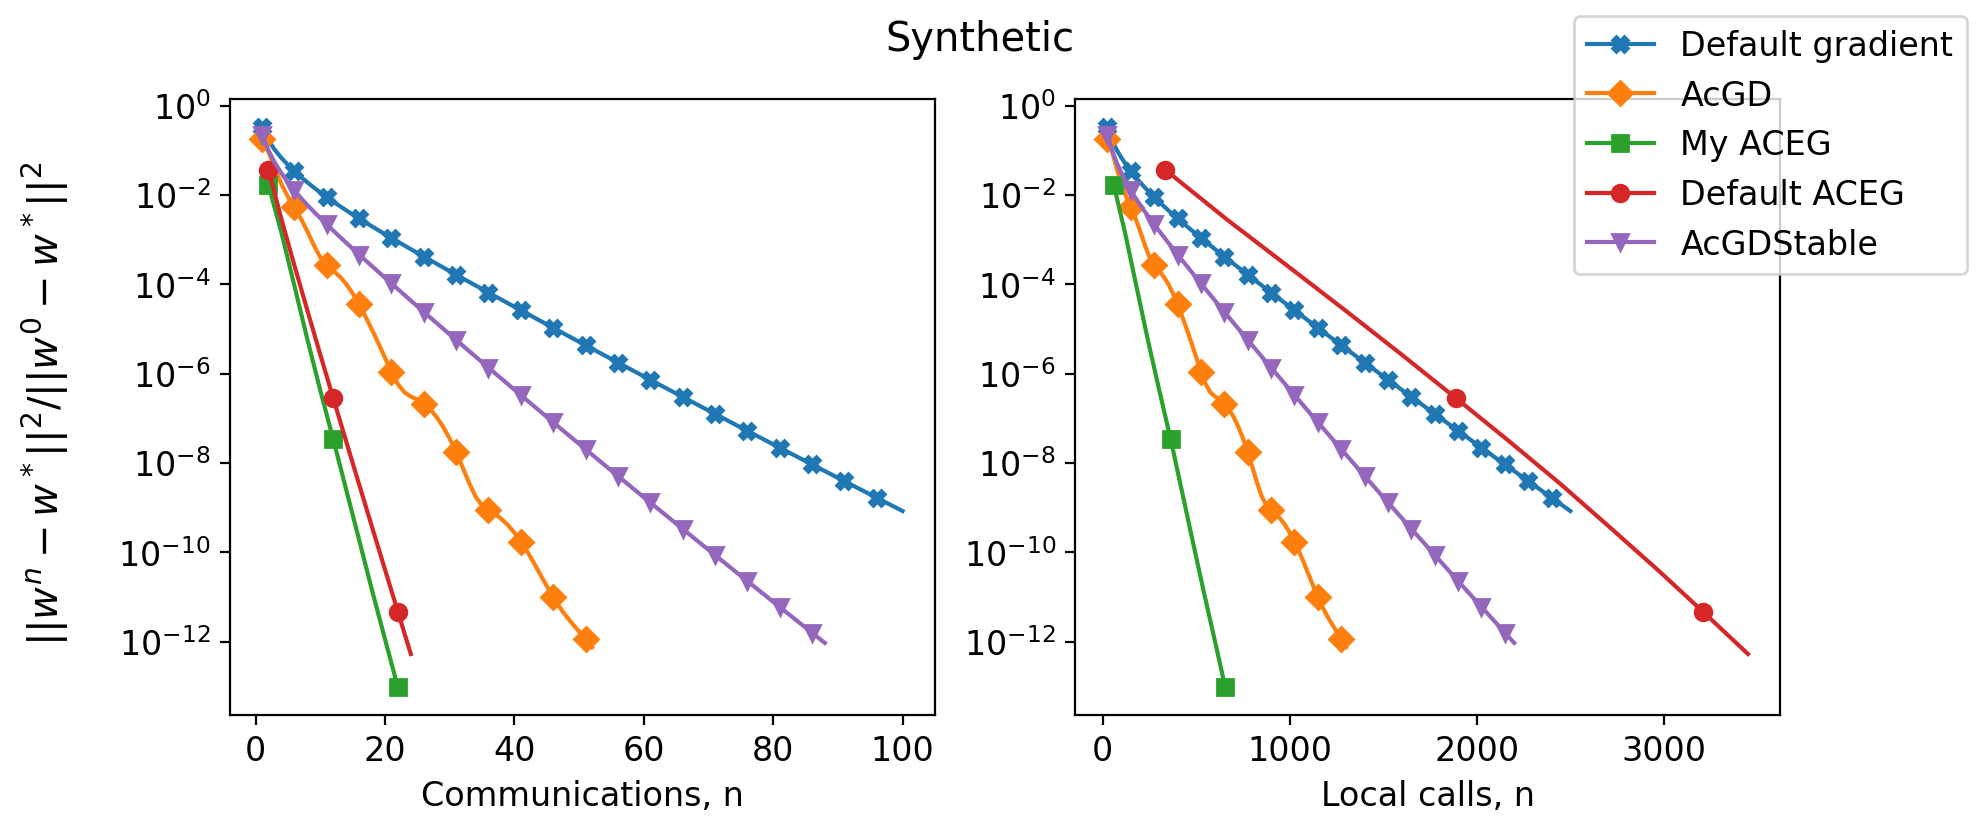

In [7]:
MakeExperiment(synthetic=True)

num_workers: 25; d: 8; cnt_worker_data: 3200;
delta: 0.33354779002405216; L: 2.1811819684262077; Lp: 0.08749158915751877; Lq: 2.234788624481871; mu: 0.2;
18 504


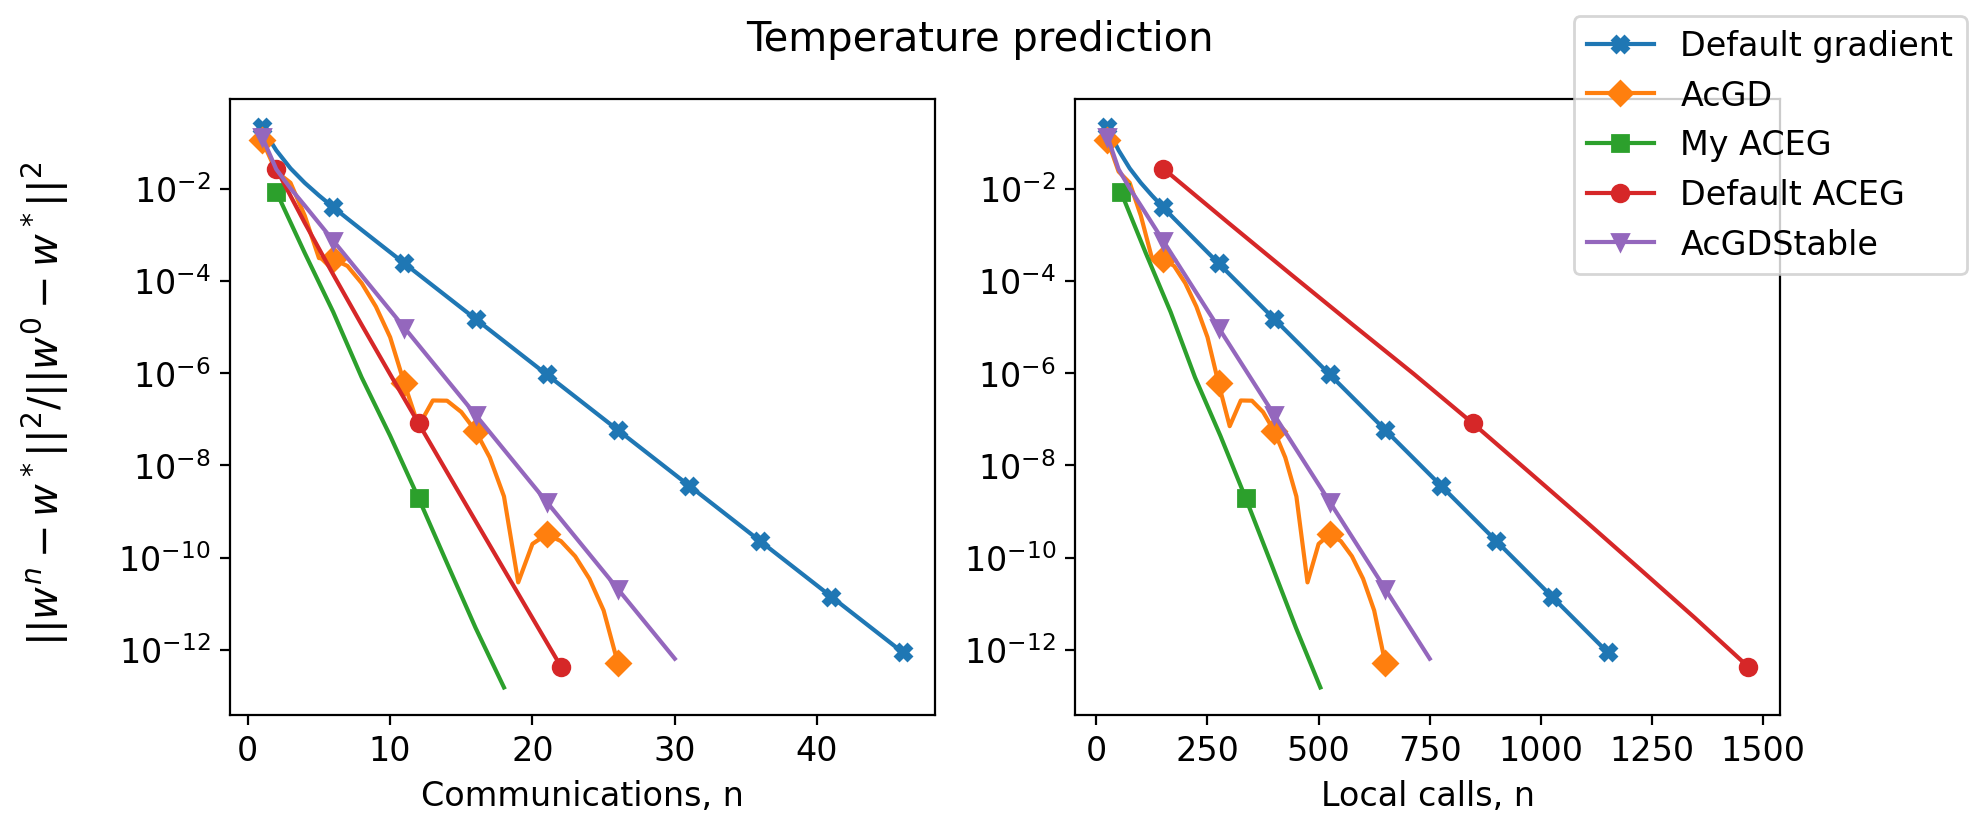

In [8]:
MakeExperiment(synthetic=False)